In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

import sklearn
import scipy
import glob
import os
import string

from pathlib import Path

import ML_utils as mlu
import Utils as ut
%matplotlib inline

In [ ]:
datasets=["10XhsBrain3kMO", "10XhsBrain3kMO","Kidney", "10XhsPBMC10kMO","10XhsPBMC10kMO", "MouseBrain"]
featurespaces=["Peak","GEX","Peak", "Peak", "GEX", "Peak"]
names=["BrP", "BrG", "KiP", "PbP", "PbG", "MbP"]

In [ ]:
for dataset, featurespace in zip(datasets, featurespaces):
    print(dataset, featurespace)
    Path(f"Datasets/{dataset}/FeatureSpaces/{featurespace}/MS").mkdir(parents=True, exist_ok=True)    

    adata=sc.read_h5ad(f"Datasets/{dataset}/FeatureSpaces/{featurespace}/CM/{dataset}_{featurespace}_QC.h5ad")
       
    y = adata.obs["target"].astype(int).to_numpy()

    adata.obsp[f"TAE_kNN"], adata.obsm[f"X_TAE"] = mlu.embbedding_and_graph(adata=adata, y=y, representation="TAE", layer="X", 
                                                                                  model_name=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/MS/{dataset}_{featurespace}_MS_TAE")
    adata.obsp[f"VAE_kNN"], adata.obsm[f"X_VAE"] = mlu.embbedding_and_graph(adata=adata, y=y, representation="VAE", layer="X",
                                                                            model_name=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/MS/{dataset}_{featurespace}_MS_VAE")
    adata.obsp[f"AE_kNN"], adata.obsm[f"X_AE"] = mlu.embbedding_and_graph(adata=adata, y=y, representation="AE", layer="X",
                                                                            model_name=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/MS/{dataset}_{featurespace}_MS_AE")
    
    if featurespace=="GEX":
        adata.obsp[f"scVI_kNN"], adata.obsm[f"X_scVI"] = mlu.embbedding_and_graph(adata=adata, y=None, representation="scVI", layer="X",
                                                                            model_name=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/MS/{dataset}_{featurespace}_MS_scVI")
    else:
        adata.obsp[f"PeakVI_kNN"], adata.obsm[f"X_PeakVI"] = mlu.embbedding_and_graph(adata=adata, y=None, representation="PeakVI", layer="X",
                                                                            model_name=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/MS/{dataset}_{featurespace}_MS_PeakVI")

    adata.obsp[f"GRAE_kNN"], adata.obsm[f"X_GRAE"] = mlu.embbedding_and_graph(adata=adata, y=y, representation="GRAE", layer="X",
                                                                            model_name=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/MS/{dataset}_{featurespace}_MS_GRAE")

 
    name=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/Dropout/siVAE/{dataset}_{featurespace}_siVAE_0_0"
    latent_space=pd.read_csv(f"{name}_latent.tsv.gz", index_col=0, sep="\t").values 
    ad_ret=sc.AnnData(scipy.sparse.csr_matrix(latent_space, dtype="float32"))
    sc.pp.neighbors(ad_ret, use_rep="X", method="umap")
    adata.obsp["siVAE_kNN"]=scipy.sparse.csr_matrix(ad_ret.obsp["connectivities"], dtype="float32")
    adata.obsm["X_siVAE"]=scipy.sparse.csr_matrix(ad_ret.X, dtype="float32")

    sc.pp.pca(adata, n_comps=int(adata.shape[1]**(1/3)))
    sc.pp.neighbors(adata, method="umap")
    adata.obsp["PCA_kNN"]=adata.obsp["connectivities"]
    adata.obsm["X_PCA"]=adata.obsm["X_pca"]
    del adata.obsp["distances"]
    del adata.obsm["X_pca"]
    del adata.obsp["connectivities"]
    
    print("Writing adata")
    adata.write(f"Datasets/{dataset}/FeatureSpaces/{featurespace}/CM/{dataset}_{featurespace}_MS.h5ad", compression="gzip")

In [ ]:
dataset="GSE117309"
featurespace="Window"
adata=sc.read_h5ad(f"Datasets/{dataset}/FeatureSpaces/{featurespace}/CM/{dataset}_{featurespace}_QC.h5ad")
y = adata.obs["target"].astype(int).to_numpy()
adata.obsp[f"GRAE_kNN"], adata.obsm[f"X_GRAE"] = mlu.embbedding_and_graph(adata=adata, y=y, representation="GRAE", layer="X",
                                                                            model_name=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/MS/{dataset}_{featurespace}_MS_GRAE")
adata.write(f"Datasets/{dataset}/FeatureSpaces/{featurespace}/CM/{dataset}_{featurespace}_MS.h5ad", compression="gzip")

# Correlation

In [ ]:
datasets=["10XhsBrain3kMO", "10XhsBrain3kMO","Kidney", "10XhsPBMC10kMO","10XhsPBMC10kMO", "MouseBrain"]
featurespaces=["Peak","GEX","Peak", "Peak", "GEX", "Peak"]
for dataset, featurespace in zip(datasets, featurespaces):
    adata=sc.read_h5ad(f"Datasets/{dataset}/FeatureSpaces/{featurespace}/CM/{dataset}_{featurespace}_MS.h5ad")
    adata.obsm["X_STD"]=adata.X
    spaces = ['X_TAE',"X_GRAE","X_scVI","X_VAE","X_AE","X_PCA"] if featurespace == "GEX" else ['X_TAE',"X_GRAE",'X_PeakVI',"X_VAE","X_AE","X_PCA"]
    for space in spaces:
        key=f"{space[2:]}_Correlation"
        if key not in list(adata.obsp.keys()):
            print(dataset, featurespace, space)
            A=np.corrcoef(scipy.sparse.csr_matrix(adata.obsm[space], dtype="float32").todense())
            adata.obsp[key]=scipy.sparse.csr_matrix(A, dtype="float32")
        else:
            print("Skipping", dataset, featurespace, key)
    adata.write(f"{dataset}/FeatureSpaces/{featurespace}/CM/{dataset}_{featurespace}_Graph.h5ad", compression="gzip")

# Distance

In [ ]:
datasets=["10XhsBrain3kMO", "10XhsBrain3kMO","Kidney", "10XhsPBMC10kMO","10XhsPBMC10kMO", "MouseBrain"]
featurespaces=["Peak","GEX","Peak", "Peak", "GEX", "Peak"]
distance="euclidean"
for dataset, featurespace in zip(datasets, featurespaces):
    adata=sc.read_h5ad(f"Datasets/{dataset}/FeatureSpaces/{featurespace}/CM/{dataset}_{featurespace}_Graph.h5ad")
    spaces = ['X_TAE',"X_GRAE","X_scVI","X_VAE","X_AE","X_PCA"] if featurespace == "GEX" else ['X_TAE',"X_GRAE",'X_PeakVI',"X_VAE","X_AE","X_PCA"]
    for space in spaces:
        key=f"{space[2:]}_Distance"
        if key not in list(adata.obsp.keys()):
            print(dataset, featurespace, space, distance)
            A=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(scipy.sparse.csr_matrix(adata.obsm[space], dtype="float32").todense(), 
                                                                             metric=distance))                
            adata.obsp[key]=scipy.sparse.csr_matrix(A, dtype="float32")
        else:
            print("Skipping", dataset, featurespace, space, key)
    adata.write(f"Datasets/{dataset}/FeatureSpaces/{featurespace}/CM/{dataset}_{featurespace}_Graph.h5ad", compression="gzip")

# Degree distributions

In [ ]:
datasets=["10XhsBrain3kMO", "10XhsBrain3kMO","Kidney", "10XhsPBMC10kMO","10XhsPBMC10kMO", "MouseBrain"]
featurespaces=["Peak","GEX","Peak", "Peak", "GEX", "Peak"]

In [ ]:
for dataset, featurespace in zip(datasets, featurespaces):
    adata=sc.read_h5ad(f"Datasets/{dataset}/FeatureSpaces/{featurespace}/CM/{dataset}_{featurespace}_Graph.h5ad")
    Path(f"Datasets/{dataset}/FeatureSpaces/{featurespace}/Graphs").mkdir(parents=True, exist_ok=True)    
    print(dataset, featurespace, sorted(list(adata.obsp.keys())))
    for graph in list(adata.obsp.keys()):
        if "kNN" not in graph:
            A=np.abs(adata.obsp[graph].todense())
            A[A == np.inf] = 0
            if graph[0]=="D":
                A=1-sklearn.preprocessing.MinMaxScaler().fit_transform(np.asarray(A))
            elif graph[0]=="C":
                A=sklearn.preprocessing.MinMaxScaler().fit_transform(np.asarray(A))
            np.fill_diagonal(A, 0)
            if np.sum(A) > A.shape[0]:
                for t in [0,1,2]:
                    file=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/Graphs/{dataset}_{featurespace}_{graph}_median_{t}.edgelist.gz"
                    if os.path.isfile(file) == False:
                        print(graph, t)
                        B=A.copy()
                        s=np.std(np.array(ut.upper_tri_masking(B)))
                        m=np.median(np.array(ut.upper_tri_masking(B)))
                        B[B < m + t*s]=0
                        nx.write_edgelist(nx.from_numpy_array(B), file)

In [ ]:
df=pd.DataFrame()
for dataset, feature in zip(datasets, featurespaces):
    files=sorted(glob.glob(f"Datasets/{dataset}/FeatureSpaces/{feature}/Graphs/{dataset}_{feature}*edgelist.gz"))
    print(dataset, feature, len(files))
    for file in files:
        new_name=file.split("/")[-1].split(".")[0]
        if new_name not in df.columns:
            try:
                print("Loading", new_name)
                G = nx.read_edgelist(file)
                degrees = sorted([G.degree(n) for n in G.nodes()])[::-1]
                d = pd.DataFrame(data=degrees)
                d.rename({0 : str(new_name)}, axis=1, inplace=True)
                df = pd.concat([df, d], axis=1)
            except:
                continue
        else:
            print("Skipping", new_name)
df.to_csv("Tables/Degree_distribution.tsv.gz", sep="\t", compression="gzip")
df.shape

# SEAGALL_SuppFig14

In [4]:
datasets=["10XhsBrain3kMO", "10XhsBrain3kMO","Kidney", "10XhsPBMC10kMO","10XhsPBMC10kMO", "MouseBrain"]
featurespaces=["Peak","GEX","Peak", "Peak", "GEX", "Peak"]
df=pd.read_csv("Tables/Degree_distribution.tsv.gz", sep="\t", index_col=0)
print(df.shape)

(5208, 146)


In [5]:
dfs={}
for dataset, feats_space in zip(datasets, featurespaces):
    print(dataset, feats_space)
    adata=sc.read_h5ad(f"Datasets/{dataset}/FeatureSpaces/{feats_space}/CM/{dataset}_{feats_space}_Graph.h5ad")
    columns=[]
    for c in list(adata.obsp.keys()):
        for i in ["0","1","2"]:
            columns.append(f"{dataset}_{feats_space}_{c}_median_{i}")
    d=pd.DataFrame()
    for col in columns:
        if col in df.columns:
            d=pd.concat([d, df[col]], axis=1)
        else:
            d[col]=0
    d=d.iloc[:adata.shape[0]]
    d.fillna(0, inplace=True)
    dfs[f"{dataset}_{feats_space}"]=d

dfs_med={}
for t in ["0","1","2"]:
    to_put=[]
    for key in dfs.keys():
        to_put.append([dfs[key][col] for col in dfs[key].columns if f"median_{t}" in col])
    dfs_med[t]=pd.concat([pd.concat(to_put[i], axis=1) for i in range(0,3)], axis=1)

10XhsBrain3kMO Peak
10XhsBrain3kMO GEX
Kidney Peak
10XhsPBMC10kMO Peak
10XhsPBMC10kMO GEX
MouseBrain Peak


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


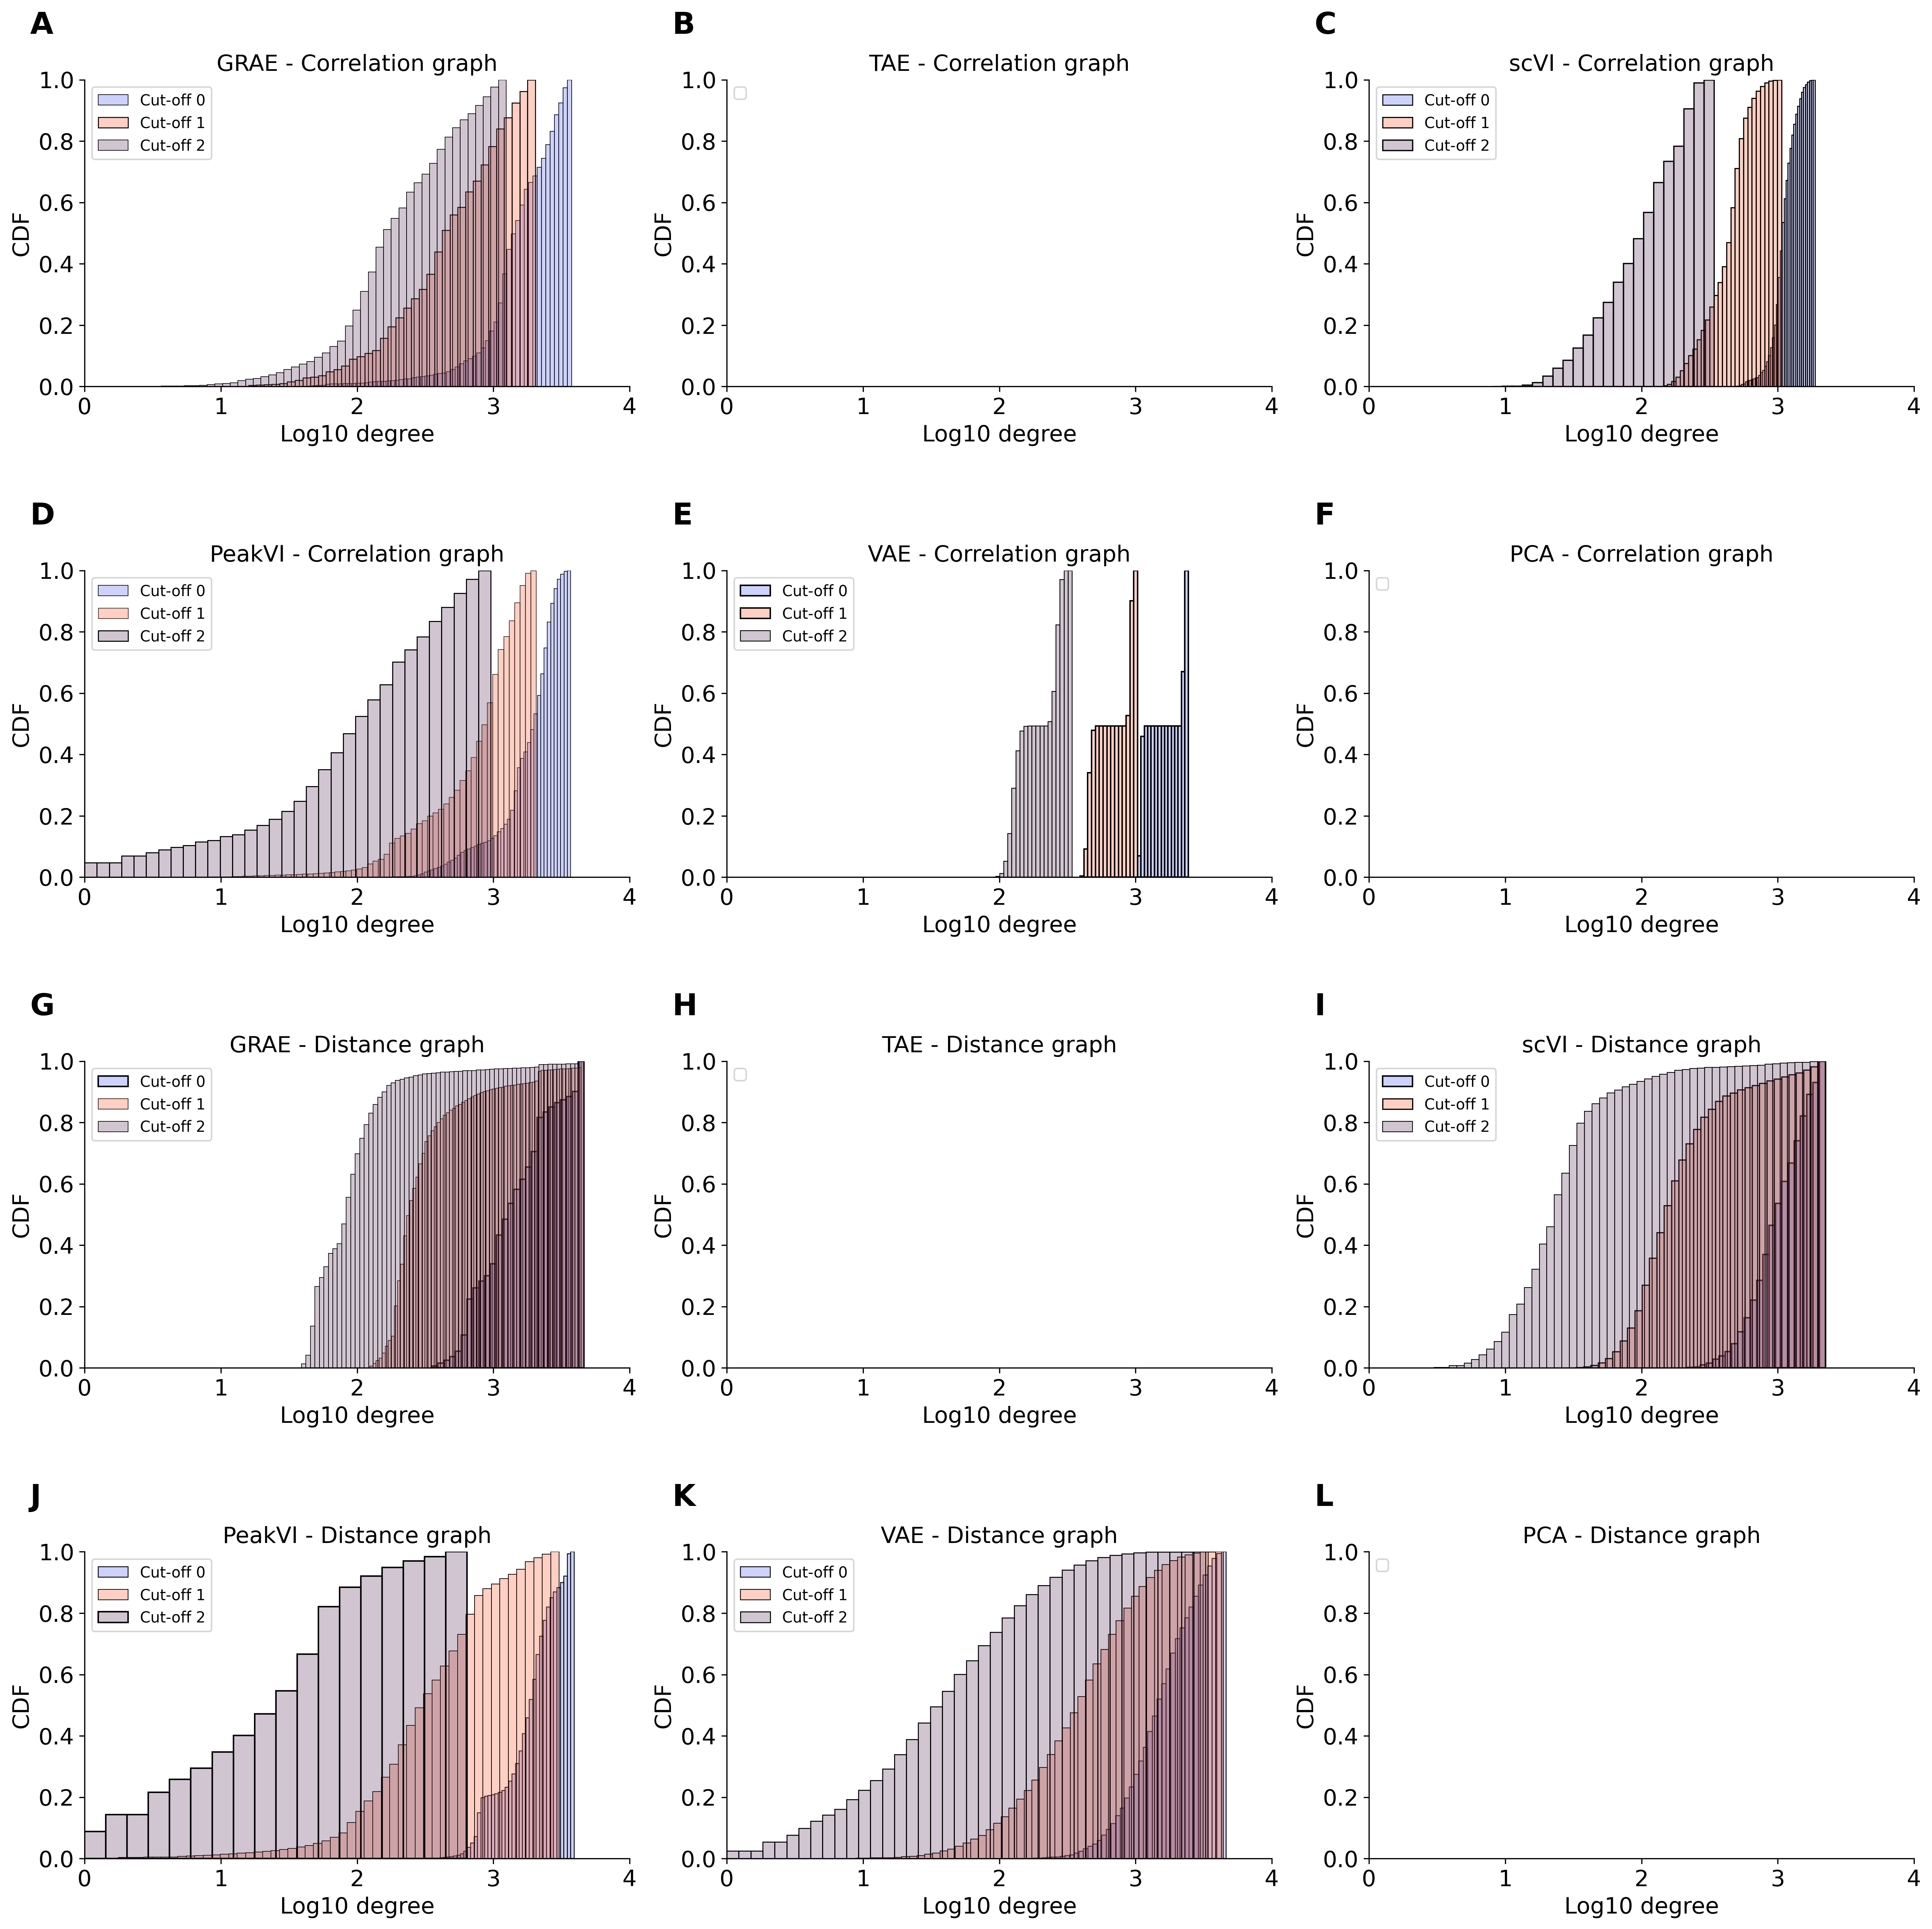

In [6]:
params = {'axes.labelsize': 15,
         'axes.titlesize': 15,
         'xtick.labelsize' : 15,
         'ytick.labelsize': 15,
         "lines.linewidth" : 4}
plt.rcParams.update(params) 
fig, axs = plt.subplots(4,3, dpi=300, figsize=(18, 18))
axs=axs.flatten()

for ax, rep in zip(axs, ["GRAE","TAE","scVI", "PeakVI","VAE","PCA"]):
    for t in [0,1,2]:
        x=dfs_med[str(t)][[col for col in dfs_med[str(t)].columns if "Corr" in col and rep in col]].values
        x=x.reshape(x.shape[0]*x.shape[1])
        x = x[~np.isnan(x)]
        sns.histplot(x=np.log10(x), stat="proportion", cumulative=True, alpha=0.3, ax=ax, color=ut.colors_to_use_bright[t], label=f"Cut-off {t}")
    ax.set_title(f"{rep} - Correlation graph")

for ax, rep in zip(axs[6:], ["GRAE","TAE","scVI", "PeakVI","VAE","PCA"]):
    for t in [0,1,2]:
        x=dfs_med[str(t)][[col for col in dfs_med[str(t)].columns if "Dist" in col and rep in col]].values
        x=x.reshape(x.shape[0]*x.shape[1])
        x = x[~np.isnan(x)]
        sns.histplot(x=np.log10(x), stat="proportion", cumulative=True, alpha=0.3, ax=ax, color=ut.colors_to_use_bright[t], label=f"Cut-off {t}")
    ax.set_title(f"{rep} - Distance graph")

for i in range(0,len(axs)):
    axs[i].text(-0.1, 1.15, string.ascii_uppercase[i], transform=axs[i].transAxes, size=20, weight='bold',rotation=0)    
for ax in axs:
    ax.set_ylim([0,1])
    ax.set_xticks([0,1,2,3,4],[0,1,2,3,4])
    ax.set_xlim([0, 4])
    ax.legend(loc="upper left")
    ax.set_xlabel("Log10 degree")
    ax.set_ylabel("CDF")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)  
    
plt.tight_layout(h_pad=3.5)
plt.savefig("Figures/SEAGALL_SuppFig14.png", format="png", dpi=300, bbox_inches='tight')
plt.show()